In [ ]:
import kagglehub
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-small' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-small


In [ ]:
!pip install faiss-cpu umap-learn

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.0 MB/s eta 0:00:00


In [ ]:
project_root = "/content/data"
os.makedirs(project_root, exist_ok=True)

shutil.copytree(path, project_root, dirs_exist_ok=True)
print("Project data folder:", project_root)
!ls /content/data

Project data folder: /content/data
images	myntradataset  styles.csv


In [ ]:
csv_path = "/content/data/styles.csv"
img_dir = "/content/data/images"

In [ ]:
df = pd.read_csv(csv_path, on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
def file_exists(img_id):
  jpg_path = os.path.join(img_dir, f"{img_id}.jpg")
  jpeg_path = os.path.join(img_dir, f"{img_id}.jpeg")
  return os.path.exists(jpg_path) or os.path.exists(jpeg_path)

df['has_image'] = df['id'].apply(file_exists)
df = df[df['has_image'] == True].copy()
df = df.drop(columns=['has_image'])
df.reset_index(drop=True, inplace=True)

print("Remaining rows:", len(df))

Remaining rows: 44419


/content/data/images/15970.jpg


(np.float64(-0.5), np.float64(59.5), np.float64(79.5), np.float64(-0.5))

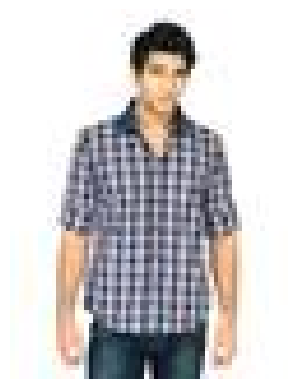

In [ ]:
sample_id = df.iloc[0]['id']
img_path = os.path.join(img_dir, f"{sample_id}.jpg")

print(img_path)

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis("off")

In [ ]:
df['masterCategory'].value_counts()

,count
masterCategory,
Apparel,21392
Accessories,11274
Footwear,9219
Personal Care,2403
Free Items,105
Sporting Goods,25
Home,1


In [ ]:
df['subCategory'].value_counts()

,count
subCategory,
Topwear,15398
Shoes,7343
Bags,3055
Bottomwear,2693
Watches,2542
Innerwear,1808
Jewellery,1079
Eyewear,1073
Fragrance,1011


In [ ]:
df['articleType'].value_counts()

,count
articleType,
Tshirts,7066
Shirts,3215
Casual Shoes,2845
Watches,2542
Sports Shoes,2036
...,...
Hair Accessory,1
Cushion Covers,1
Mens Grooming Kit,1


In [ ]:
category_map = {
  'Topwear': ['Tshirts', 'Shirts', 'Tops', 'Blouses', 'Sweaters', 'Sweatshirts'],
  'Bottomwear': ['Jeans', 'Trousers', 'Shorts', 'Skirts', 'Jeggings'],
  'Dress': ['Dresses', 'Jumpsuit'],
  'Shoes': ['Casual Shoes', 'Sports Shoes', 'Sneakers', 'Flats', 'Heels', 'Sandals']
}

def map_to_main_category(article):
  for main_cat, sub_list in category_map.items():
    if article in sub_list:
      return main_cat
  return None

df['cleanCategory'] = df['articleType'].apply(map_to_main_category)
df = df[df['cleanCategory'].notnull()].copy()
df.reset_index(drop=True, inplace=True)

In [ ]:
df['cleanCategory'].value_counts()

,count
cleanCategory,
Topwear,12605
Shoes,7601
Bottomwear,1847
Dress,480


In [ ]:
cleaned_csv_path = "/content/data/filtered_styles.csv"
df.to_csv(cleaned_csv_path, index=False)

print("Saved filtered dataset to:", cleaned_csv_path)

Saved filtered dataset to: /content/data/filtered_styles.csv


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os

In [ ]:
img_size = 224

train_transform = T.Compose([
  T.Resize((img_size, img_size)),
  T.RandomHorizontalFlip(),
  T.ColorJitter(brightness=0.2, contrast=0.2),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
  T.Resize((img_size, img_size)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
csv_path = "/content/data/filtered_styles.csv"
df = pd.read_csv(csv_path)
df.head()

In [ ]:
df['cleanCategory'].value_counts()

In [ ]:
class_names = sorted(df['cleanCategory'].unique())
class_to_idx = {c: i for i, c in enumerate(class_names)}

df['label'] = df['cleanCategory'].map(class_to_idx)
df.head()

In [ ]:
compat_map = {
  "Topwear": ["Bottomwear", "Shoes"],
  "Bottomwear": ["Topwear", "Shoes"],
  "Dress": ["Shoes"],
  "Shoes": ["Topwear", "Bottomwear", "Dress"]
}

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.shape, val_df.shape

In [ ]:
class FashionDataset(Dataset):
  def __init__(self, df, img_dir, transform):
    self.df = df.reset_index(drop=True)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_id = row['id']
    img_path_jpg = os.path.join(self.img_dir, f"{img_id}.jpg")
    img_path_jpeg = os.path.join(self.img_dir, f"{img_id}.jpeg")

    if os.path.exists(img_path_jpg):
      path = img_path_jpg
    else:
      path = img_path_jpeg

    img = Image.open(path).convert("RGB")
    img = self.transform(img)

    label = int(row['label'])
    return img, label

In [ ]:
img_dir = "/content/data/images"

train_ds = FashionDataset(train_df, img_dir, train_transform)
val_ds   = FashionDataset(val_df, img_dir, val_transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
batch = next(iter(train_loader))
imgs, labels = batch
imgs.shape, labels.shape

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()

backbone = backbone.to(device)

In [ ]:
class ClassifierHead(nn.Module):
  def __init__(self, in_dim, num_classes, dropout_p=0.3):
    super().__init__()
    self.fc1 = nn.Linear(in_dim, 512)
    self.relu = nn.ReLU(inplace=True)
    self.drop = nn.Dropout(dropout_p)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.fc2(x)
    return x

clf_head = ClassifierHead(num_features, len(class_names)).to(device)

In [ ]:
params = list(backbone.parameters()) + list(clf_head.parameters())

optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch():
  backbone.train()
  clf_head.train()

  total_loss = 0
  total_correct = 0
  total_samples = 0

  for imgs, labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    feats = backbone(imgs)
    logits = clf_head(feats)

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    preds = logits.argmax(dim=1)
    total_correct += (preds == labels).sum().item()
    total_samples += labels.size(0)
    total_loss += loss.item() * labels.size(0)

  return total_loss / total_samples, total_correct / total_samples

In [ ]:
def validate():
  backbone.eval()
  clf_head.eval()

  total_loss = 0
  total_correct = 0
  total_samples = 0

  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)

      feats = backbone(imgs)
      logits = clf_head(feats)
      loss = criterion(logits, labels)

      preds = logits.argmax(dim=1)
      total_correct += (preds == labels).sum().item()
      total_samples += labels.size(0)
      total_loss += loss.item() * labels.size(0)

  return total_loss / total_samples, total_correct / total_samples

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  train_loss, train_acc = train_one_epoch()
  val_loss, val_acc = validate()

  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")

Epoch 1/5
  Train Loss: 0.1028, Train Acc: 0.9697
  Val Loss:   0.0360, Val Acc:   0.9909
Epoch 2/5
  Train Loss: 0.0193, Train Acc: 0.9945
  Val Loss:   0.0359, Val Acc:   0.9920
Epoch 3/5
  Train Loss: 0.0131, Train Acc: 0.9960
  Val Loss:   0.0407, Val Acc:   0.9905
Epoch 4/5
  Train Loss: 0.0090, Train Acc: 0.9977
  Val Loss:   0.0269, Val Acc:   0.9931
Epoch 5/5
  Train Loss: 0.0079, Train Acc: 0.9970
  Val Loss:   0.0396, Val Acc:   0.9909


In [ ]:
import torch

save_path = "/content/backbone_classifier.pth"
torch.save({
  'backbone': backbone.state_dict(),
  'clf_head': clf_head.state_dict(),
  'class_names': class_names,
}, save_path)

print("Model saved to:", save_path)

Model saved to: /content/backbone_classifier.pth


In [ ]:
import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("/content/data/filtered_styles.csv")

backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
backbone.fc = torch.nn.Identity()
backbone.to(device)

class ClassifierHead(torch.nn.Module):
  def __init__(self, in_dim, num_classes, dropout_p=0.3):
    super().__init__()
    self.fc1 = torch.nn.Linear(in_dim, 512)
    self.relu = torch.nn.ReLU(inplace=True)
    self.drop = torch.nn.Dropout(dropout_p)
    self.fc2 = torch.nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.fc2(x)
    return x

clf_head = ClassifierHead(2048, len(class_names)).to(device)

checkpoint = torch.load("/content/backbone_classifier.pth", map_location=device)
backbone.load_state_dict(checkpoint['backbone'])
clf_head.load_state_dict(checkpoint['clf_head'])

backbone.eval()
clf_head.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
embed_transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [ ]:
from PIL import Image
import torch.nn.functional as F
import os

def get_embedding_and_category(path):
  img = Image.open(path).convert("RGB")
  img = embed_transform(img)
  img = img.unsqueeze(0).to(device)

  with torch.no_grad():
    feat = backbone(img)
    feat = F.normalize(feat, dim=1)
    logits = clf_head(feat)
    pred_label = logits.argmax(dim=1).item()

  return feat.cpu().numpy().flatten(), pred_label

In [ ]:
import numpy as np

emb_list = []
label_list = []
id_list = []

for idx, row in df.iterrows():
  img_id = row['id']
  jpg_path = os.path.join(img_dir, f"{img_id}.jpg")
  jpeg_path = os.path.join(img_dir, f"{img_id}.jpeg")

  if os.path.exists(jpg_path):
    path = jpg_path
  elif os.path.exists(jpeg_path):
    path = jpeg_path
  else:
    continue

  emb, pred = get_embedding_and_category(path)
  emb_list.append(emb)
  label_list.append(pred)
  id_list.append(img_id)

embeddings = np.vstack(emb_list).astype('float32')
predicted_labels = np.array(label_list)
ids = np.array(id_list)

print("Embedding matrix shape:", embeddings.shape)

Embedding matrix shape: (22533, 2048)


In [ ]:
np.save("/content/embeddings.npy", embeddings)

df_embed = pd.DataFrame({"id": ids, "pred_label": predicted_labels})
df_embed.to_csv("/content/embeddings_metadata.csv", index=False)

print("Saved embeddings + metadata!")

Saved embeddings + metadata!


In [ ]:
import faiss

d = embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(d)
faiss_index.add(embeddings)

print("FAISS index size:", faiss_index.ntotal)

FAISS index size: 22533


In [ ]:
query_emb = embeddings[0:1]
D, I = faiss_index.search(query_emb, k=5)

print("Distances:", D)
print("IDs:", I)

Distances: [[0.99999994 0.94809824 0.9469642  0.94398    0.94354814]]
IDs: [[    0  1927 17085 19126 16594]]


In [ ]:
def get_image_path(img_id):
  jpg_path = os.path.join(img_dir, f"{img_id}.jpg")
  jpeg_path = os.path.join(img_dir, f"{img_id}.jpeg")
  if os.path.exists(jpg_path):
    return jpg_path
  elif os.path.exists(jpeg_path):
    return jpeg_path
  else:
    return None

In [ ]:
def show_similar_items_with_labels(query_index=0, k=5):
  query_emb = embeddings[query_index:query_index+1]
  D, I = faiss_index.search(query_emb, k + 1)
  neighbor_indices = [idx for idx in I[0] if idx != query_index][:k]

  plt.figure(figsize=(3*(k+1), 4))

  qrow = df_embed.iloc[query_index]
  qid = qrow["id"]
  qlabel = class_names[qrow["pred_label"]]
  qpath = get_image_path(qid)

  plt.subplot(1, k+1, 1)
  plt.imshow(Image.open(qpath).convert("RGB"))
  plt.axis("off")
  plt.title(f"Query\n{qlabel}")

  for i, idx in enumerate(neighbor_indices, start=2):
    row = df_embed.iloc[idx]
    rid = row["id"]
    rlabel = class_names[row["pred_label"]]
    rpath = get_image_path(rid)

    plt.subplot(1, k+1, i)
    plt.imshow(Image.open(rpath).convert("RGB"))
    plt.axis("off")
    plt.title(f"{rlabel}")

  plt.tight_layout()
  plt.show()

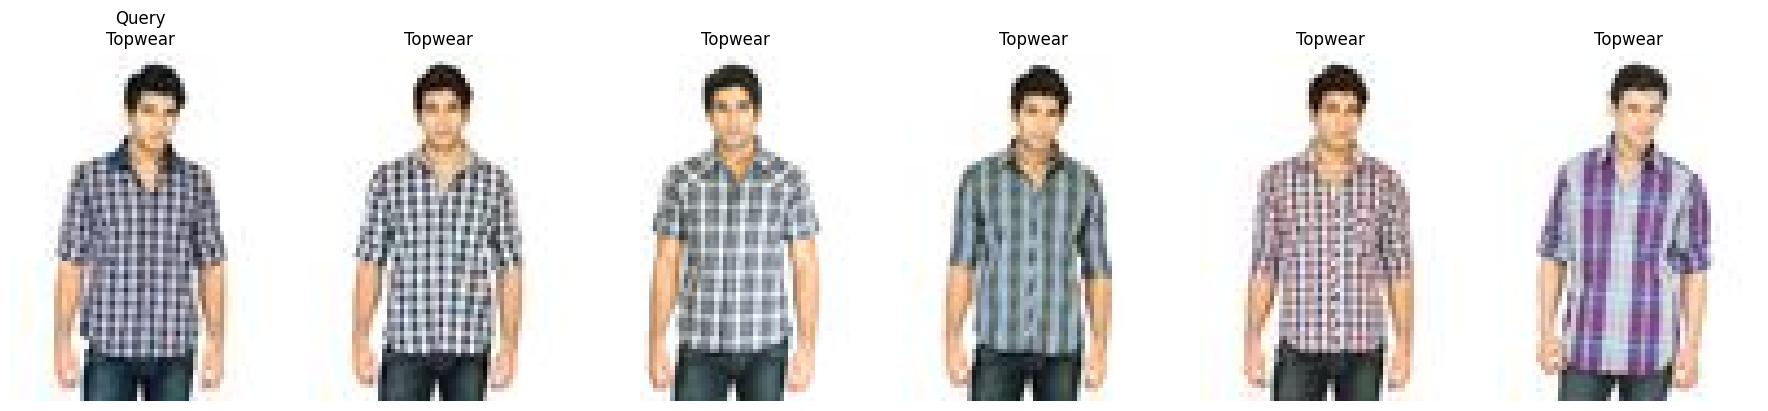

In [ ]:
show_similar_items_with_labels(0, k=5)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_compatible_outfits(query_index=0, show_k=5):
  """
  query_index: index in embeddings/df_embed
  show_k: how many compatible items to display
  """
  query_row = df_embed.iloc[query_index]
  query_id = query_row["id"]
  query_label_idx = int(query_row["pred_label"])
  query_cat = class_names[query_label_idx]

  allowed_cats = compat_map.get(query_cat, [])
  if not allowed_cats:
    print(f"No compatibility rule for category: {query_cat}")
    return

  query_emb = embeddings[query_index:query_index+1]
  sims = embeddings @ query_emb.T
  sims = sims.squeeze()

  all_pred_labels = df_embed["pred_label"].values
  all_cats = np.array([class_names[int(i)] for i in all_pred_labels])

  mask = np.ones(len(df_embed), dtype=bool)
  mask[query_index] = False
  mask &= np.isin(all_cats, allowed_cats)

  candidate_indices = np.where(mask)[0]

  if len(candidate_indices) == 0:
    print("No compatible items found with current rules (even globally).")
    return

  candidate_sims = sims[candidate_indices]
  sorted_idx = np.argsort(-candidate_sims)
  top_indices = candidate_indices[sorted_idx[:show_k]]

  plt.figure(figsize=(3 * (len(top_indices) + 1), 4))

  qpath = get_image_path(query_id)
  if qpath is None:
    print("Query image not found on disk.")
    return

  qimg = Image.open(qpath).convert("RGB")
  plt.subplot(1, len(top_indices) + 1, 1)
  plt.imshow(qimg)
  plt.axis("off")
  plt.title(f"Query\n{query_cat}")

  for i, idx in enumerate(top_indices, start=2):
    row = df_embed.iloc[idx]
    rid = row["id"]
    r_label_idx = int(row["pred_label"])
    r_cat = class_names[r_label_idx]
    rpath = get_image_path(rid)

    if rpath is None:
      continue

    rimg = Image.open(rpath).convert("RGB")
    plt.subplot(1, len(top_indices) + 1, i)
    plt.imshow(rimg)
    plt.axis("off")
    plt.title(r_cat)

  plt.tight_layout()
  plt.show()

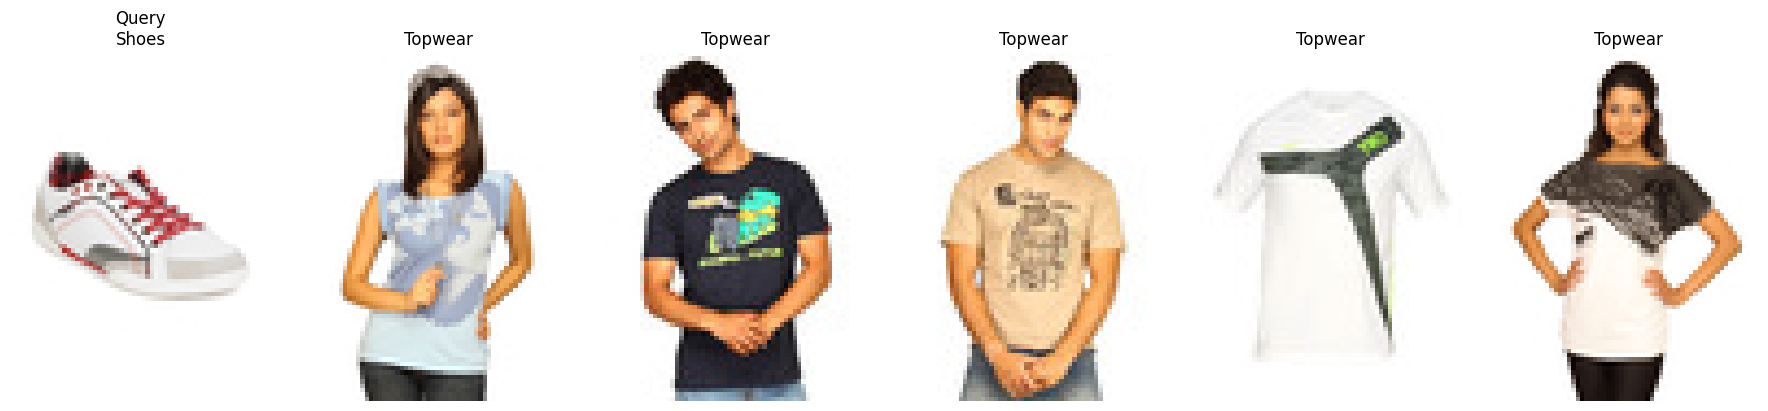

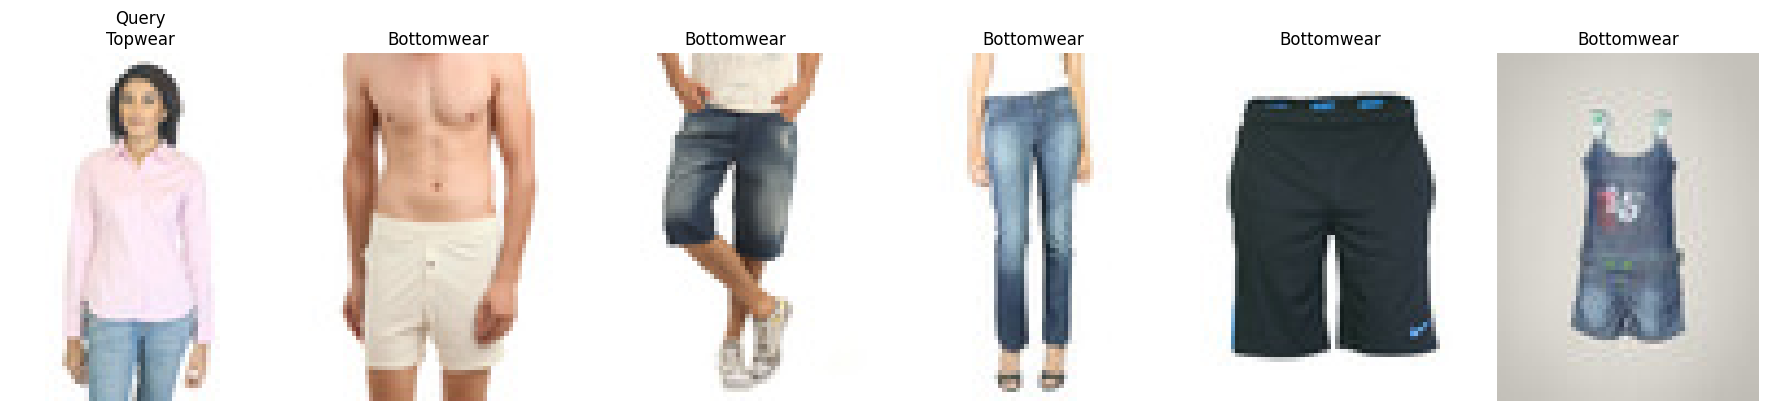

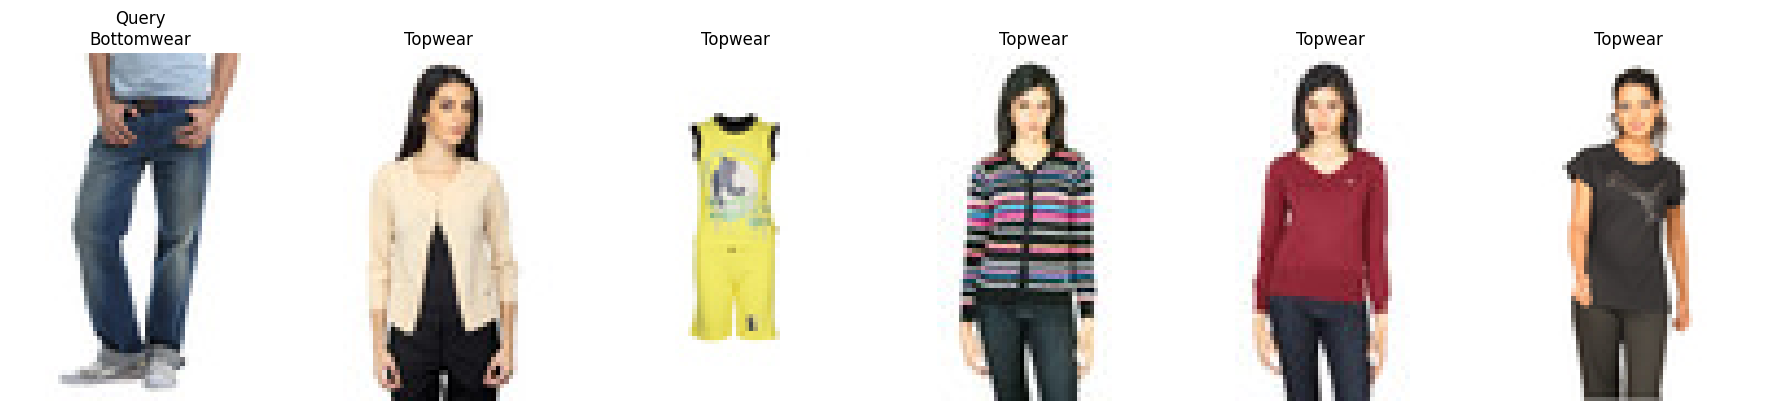

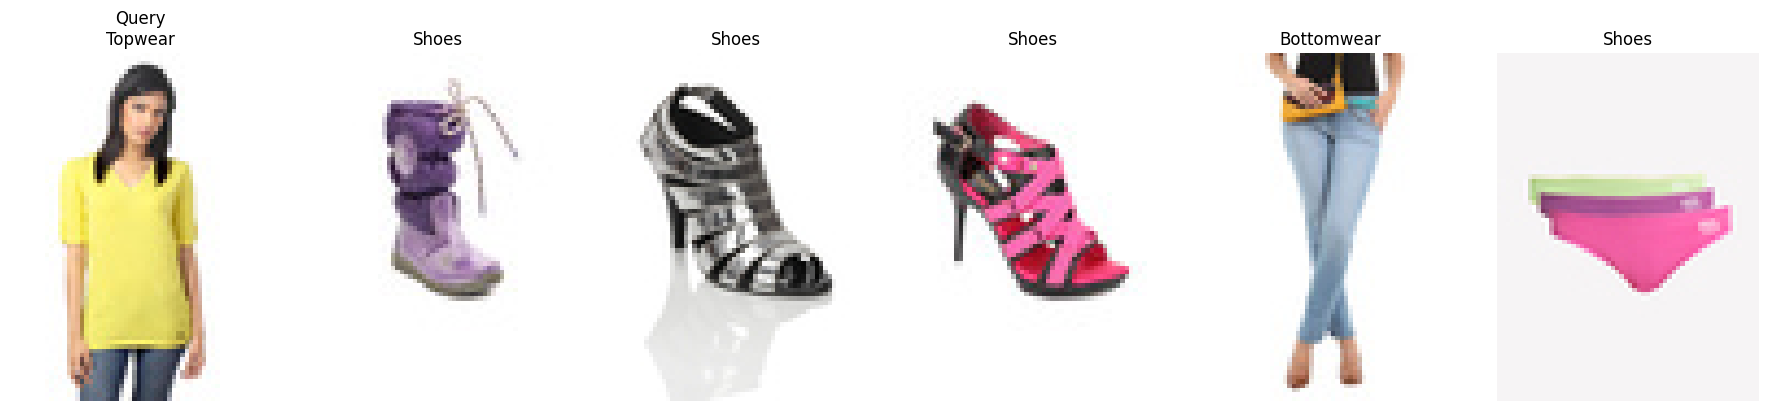

In [ ]:
show_compatible_outfits(query_index=15, show_k=5)
show_compatible_outfits(query_index=1503, show_k=5)
show_compatible_outfits(query_index=2323, show_k=5)

idx = np.random.randint(0, len(df_embed))
show_compatible_outfits(query_index=idx, show_k=5)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

backbone.eval()
clf_head.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for imgs, labels in val_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    feats = backbone(imgs)
    logits = clf_head(feats)
    preds = logits.argmax(dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

              precision    recall  f1-score   support

  Bottomwear      0.995     0.989     0.992       370
       Dress      0.765     0.917     0.834        96
       Shoes      0.999     0.998     0.999      1520
     Topwear      0.996     0.990     0.993      2521

    accuracy                          0.991      4507
   macro avg      0.939     0.973     0.954      4507
weighted avg      0.992     0.991     0.991      4507



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
#cm

array([[ 366,    2,    1,    1],
       [   1,   88,    0,    7],
       [   0,    0, 1517,    3],
       [   1,   25,    0, 2495]])

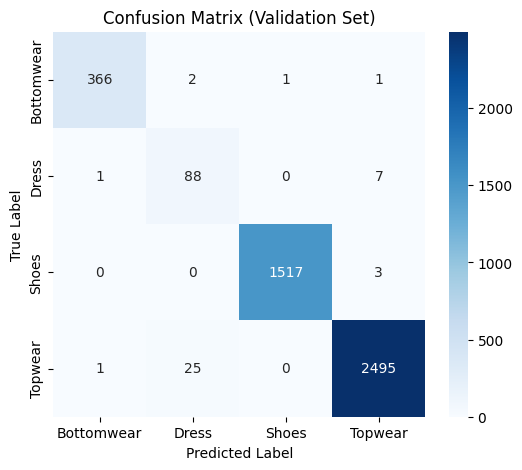

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

AI disclaimer: We didn't use AI to generate majority of the code and the logic behind our project. We referred a lot to lectures. ChatGPT and Google Gemini was used to debug certain things like getting the embedding. Also used AI to make a better confusion matrix. The confusion matrix code that we generated was right before the Seaborn one.